In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def BinaryCIFAR10create_imbalanced_datasets(
        root='data',
        download=True,
        batch_size=64,
        random_seed = 42,
        fractions=[0.01, 0.02, 0.05, 0.1, 0.2],
):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    cifar_transform = transforms.ToTensor()
    Full_train_dataset = datasets.CIFAR10(root=root, train=True, transform=cifar_transform, download=download)
    
    train_data = torch.tensor(Full_train_dataset.data, dtype=torch.float)
    train_labels = torch.tensor(Full_train_dataset.targets, dtype=torch.long)
    
     # Permute the training data to be [N, C, H, W] => [N, 3, 32, 32]
    train_data = train_data.permute(0, 3, 1, 2)


    train_index_label3 = (train_labels == 3) # 3 is cat
    train_index_label4 = (train_labels == 4) # 4 is deer

    train_data_label3 = train_data[train_index_label3]
    train_data_label4 = train_data[train_index_label4]
    train_labels_label3 = train_labels[train_index_label3]
    train_labels_label4 = train_labels[train_index_label4]

    num_label4 = len(train_data_label4)
    num_label3 = len(train_data_label3)
    print('Number of images with label 3:', num_label3)
    print('Number of images with label 4:', num_label4)

    train_datasets_dict = {}
    for fraction in fractions:
        num_label3_need = int(num_label4 * fraction)
        # Randomly choose a subset of label-3 images
        chosen_indices_label3 = np.random.choice(len(train_data_label3), num_label3_need, replace=False)
        subset_label3_data = train_data_label3[chosen_indices_label3]
        subset_label3_labels = train_labels_label3[chosen_indices_label3]

        # Concatenate label-4 data with the chosen subset of label-3 data
        new_train_data = torch.cat((train_data_label4, subset_label3_data), dim=0)
        new_train_labels = torch.cat((train_labels_label4, subset_label3_labels), dim=0)

        # Create a new training dataset
        new_train_dataset = TensorDataset(new_train_data, new_train_labels)
        train_dataloader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
        train_datasets_dict[f'train_{fraction}'] = train_dataloader


    test_dataset = datasets.CIFAR10(root=root, train=False, transform=cifar_transform, download=download)
    test_data_raw = torch.tensor(test_dataset.data, dtype=torch.float)
    test_labels_raw = torch.tensor(test_dataset.targets, dtype=torch.long)

    test_data_raw = test_data_raw.permute(0, 3, 1, 2)

    test_index_label34 = (test_labels_raw == 3) | (test_labels_raw == 4)
    test_data = test_data_raw[test_index_label34]
    test_labels = test_labels_raw[test_index_label34]
    test_dataset = TensorDataset(test_data, test_labels)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    data_loaders_dict = {**train_datasets_dict, **{'test': test_dataloader}}
    return data_loaders_dict

In [3]:
if __name__ == '__main__':
    BinaryCIFAR10DataLoader = BinaryCIFAR10create_imbalanced_datasets(
        root = '/Users/max/MasterThesisData/CIFAR10',
        download=True,
        batch_size=64,
        random_seed = 42,
        fractions=[0.01, 0.02, 0.05, 0.1, 0.2],
    )
    CIFAR10_train_loader001 = BinaryCIFAR10DataLoader['train_0.01']
    CIFAR10_train_loader002 = BinaryCIFAR10DataLoader['train_0.02']
    CIFAR10_train_loader005 = BinaryCIFAR10DataLoader['train_0.05']
    CIFAR10_train_loader010 = BinaryCIFAR10DataLoader['train_0.1']
    CIFAR10_train_loader020 = BinaryCIFAR10DataLoader['train_0.2']
    CIFAR10_test_loader = BinaryCIFAR10DataLoader['test']

    print('Number of batches in train_loader_0.01:', len(CIFAR10_train_loader001))
    print('Number of batches in train_loader_0.02:', len(CIFAR10_train_loader002))
    print('Number of batches in train_loader_0.05:', len(CIFAR10_train_loader005))
    print('Number of batches in train_loader_0.1:', len(CIFAR10_train_loader010))
    print('Number of batches in train_loader_0.2:', len(CIFAR10_train_loader020))
    print('Number of batches in test_loader:', len(CIFAR10_test_loader))
    print('Number of images in train_loader_0.01:', len(CIFAR10_train_loader001.dataset))
    print('Number of images in train_loader_0.02:', len(CIFAR10_train_loader002.dataset))
    print('Number of images in train_loader_0.05:', len(CIFAR10_train_loader005.dataset))
    print('Number of images in train_loader_0.1:', len(CIFAR10_train_loader010.dataset))
    print('Number of images in train_loader_0.2:', len(CIFAR10_train_loader020.dataset))
    print('Number of images in test_loader:', len(CIFAR10_test_loader.dataset))

100.0%


Number of images with label 3: 5000
Number of images with label 4: 5000
Number of batches in train_loader_0.01: 79
Number of batches in train_loader_0.02: 80
Number of batches in train_loader_0.05: 83
Number of batches in train_loader_0.1: 86
Number of batches in train_loader_0.2: 94
Number of batches in test_loader: 32
Number of images in train_loader_0.01: 5050
Number of images in train_loader_0.02: 5100
Number of images in train_loader_0.05: 5250
Number of images in train_loader_0.1: 5500
Number of images in train_loader_0.2: 6000
Number of images in test_loader: 2000


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def Binary_get_class_distribution(data_loader):
    num_label3 = 0
    num_label4 = 0
    for _, label in data_loader:
        num_label3 += (label == 3).sum().item()
        num_label4 += (label == 4).sum().item()
    
    total_label = num_label3 + num_label4
    percentage_label3 = (num_label3 / total_label)
    percentage_label4 = (num_label4 / total_label)

    
    return percentage_label3, percentage_label4

In [5]:
per_label3_001, per_label4_001 = Binary_get_class_distribution(CIFAR10_train_loader001)
per_label3_002, per_label4_002 = Binary_get_class_distribution(CIFAR10_train_loader002)
per_label3_005, per_label4_005 = Binary_get_class_distribution(CIFAR10_train_loader005)
per_label3_010, per_label4_010 = Binary_get_class_distribution(CIFAR10_train_loader010)
per_label3_020, per_label4_020 = Binary_get_class_distribution(CIFAR10_train_loader020)
per_label3_test, per_label4_test = Binary_get_class_distribution(CIFAR10_test_loader)

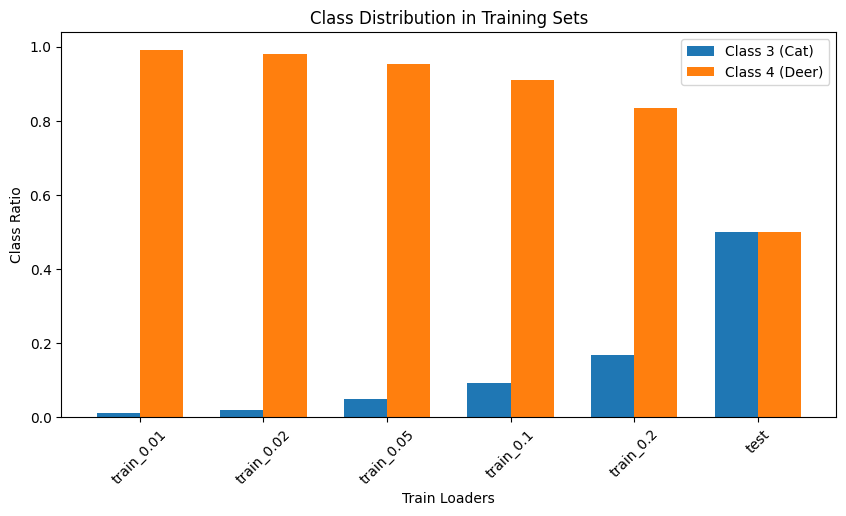

In [7]:
def visualize_distribution(train_loaders):
    class_3_ratios = []
    class_4_ratios = []
    train_names = []

    for name, loader in train_loaders.items():
        p3, p4 = Binary_get_class_distribution(loader)
        train_names.append(name)
        class_3_ratios.append(p3)
        class_4_ratios.append(p4)

    x = np.arange(len(train_names))
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - bar_width/2, class_3_ratios, bar_width, label="Class 3 (Cat)")
    ax.bar(x + bar_width/2, class_4_ratios, bar_width, label="Class 4 (Deer)")

    ax.set_xlabel("Train Loaders")
    ax.set_ylabel("Class Ratio")
    ax.set_title("Class Distribution in Training Sets")
    ax.set_xticks(x)
    ax.set_xticklabels(train_names, rotation=45)
    ax.legend()

    plt.show()

# 可视化训练集类别比例
visualize_distribution(BinaryCIFAR10DataLoader)